In [1]:
import numpy as np
import tensorflow as tf
from six.moves import range
from six.moves import cPickle as pickle
from __future__ import print_function


In [2]:
pickle_file = 'SVHN.pickle'

with open(pickle_file, 'rb') as f:
    
    test_labels = save['test_labels']
    test_filenames = save['test_filenames']
    valid_dataset = save['valid_data']
    valid_labels = save['valid_labels']
    save = pickle.load(f)
    train_dataset = save['train_data']
    train_labels = save['train_labels']
    test_dataset = save['test_data']
    
    del save
    
    print('Training dataset', train_dataset.shape, train_labels.shape)
    print('Validation dataset', valid_dataset.shape, valid_labels.shape)
    print('Test dataset', test_dataset.shape, test_labels.shape)

Training set (83401, 32, 32, 1) (83401, 6)
Validation set (152353, 32, 32, 1) (152353, 6)
Test set (13068, 32, 32, 1) (13068, 6)


In [3]:
from sklearn.utils import shuffle

valid_dataset, valid_labels = shuffle(valid_dataset, valid_labels)

valid_labels = valid_labels[:10000]
valid_dataset = valid_dataset[:10000, :, :, :]


print('Validation dataset', valid_dataset.shape, valid_labels.shape)

Validation set (10000, 32, 32, 1) (10000, 6)


In [4]:
def LecunLCN(X, image_shape, threshold=1e-4, radius=7, use_divisor=True):
    """Local Contrast Normalization (LCN): is inspired by computational neuroscience models. """

    # Get Gaussian filter
    filter_shape = (radius, radius, image_shape[3], 1)

    filters = gauss_filter(filter_shape)
    X = tf.convert_to_tensor(X, dtype=tf.float32)

    convout = tf.nn.conv2d(X, filters, [1,1,1,1], 'SAME')

    # Subtractive step
    mid = int(np.floor(filter_shape[1] / 2.))

    # Make filter dimension broadcastable and subtract
    centered_X = tf.sub(X, convout)

    # Boolean marks whether or not to perform divisive step
    if use_divisor:
        # Note that the local variances can be computed by using the centered_X
        # tensor. If we convolve this with the mean filter, that should give us
        # the variance at each point. We simply take the square root to get our
        # denominator

        # Compute variances
        sum_sqr_XX = tf.nn.conv2d(tf.square(centered_X), filters, [1,1,1,1], 'SAME')

        # Take square root to get local standard deviation
        denom = tf.sqrt(sum_sqr_XX)

        per_img_mean = tf.reduce_mean(denom)
        divisor = tf.maximum(per_img_mean, denom)
        # Divisise step
        new_X = tf.truediv(centered_X, tf.maximum(divisor, threshold))
    else:
        new_X = centered_X
    return new_X

def gauss_filter(kernel_shape):
    x = np.zeros(kernel_shape, dtype = float)
    mid = np.floor(kernel_shape[0] / 2.)
    
    for kernel_idx in xrange(0, kernel_shape[2]):
        for i in xrange(0, kernel_shape[0]):
            for j in xrange(0, kernel_shape[1]):
                x[i, j, kernel_idx, 0] = gauss(i - mid, j - mid)
    
    return tf.convert_to_tensor(x / np.sum(x), dtype=tf.float32)

def gauss(x, y, sigma=3.0):
    Z = 2 * np.pi * sigma ** 2
    return  1. / Z * np.exp(-(x ** 2 + y ** 2) / (2. * sigma ** 2))

In [5]:
def accuracy(predictions, labels, printstat=False):
    return (100.0 * np.sum(np.argmax(predictions, 2).T == labels) / predictions.shape[1] / predictions.shape[0])

In [6]:
size_of_image = 32
number_of_labels = 11 ## 0-9 & blank 
number_of_channels = 1 ## grayscale
size_of_train = train_labels.shape[0]

batch_size = 64
patch_size = 5
depth_a = 32
depth_b = 64
depth_c = 128
hidden_number1 = 512
hidden_number2 = 128
hidden_number3 = 32
shape = [batch_size, size_of_image, size_of_image, number_of_channels]

# A 7-layer CNN:
    # C1: Conv layer filter size: 5 x 5 x 1 x 32 (input batch_size x size_of_image x size_of_image x 1)
    # P2: Max pooling layer
    # C3: Conv layer filter size: 5 x 5 x 32 x 64
    # P4: Max pooling layer 
    # C5: Conv layer filter size: 5 x 5 x 64 x 512
    # D6: Dropout
    # F7: Fully connected layer, weight size: 64 x 11

graph = tf.Graph()
with graph.as_default():

    # Input data placeholders.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, size_of_image, size_of_image, number_of_channels))
    tf_train_labels = tf.placeholder(tf.int32, shape=(batch_size, 6))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
  
    # Variables.
    layer1_weights = tf.get_variable("W1", shape=[patch_size, patch_size, number_of_channels, depth_a],\
                                     initializer=tf.contrib.layers.xavier_initializer_conv2d())
    layer1_biases = tf.Variable(tf.constant(1.0, shape=[depth_a]), name='B1')
    
    layer2_weights = tf.get_variable("W2", shape=[patch_size, patch_size, depth_a, depth_b],\
                                     initializer=tf.contrib.layers.xavier_initializer_conv2d())
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth_b]), name='B2')
    
    layer3_weights = tf.get_variable("W3", shape=[patch_size, patch_size, depth_b, hidden_number1],\
                                     initializer=tf.contrib.layers.xavier_initializer_conv2d())
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[hidden_number1]), name='B3')

    s1_w1 = tf.get_variable("WS11", shape=[hidden_number1, hidden_number2],\
                           initializer=tf.contrib.layers.xavier_initializer())
    s1_b1 = tf.Variable(tf.constant(1.0, shape=[hidden_number2]), name='BS11')
    
    s2_w1 = tf.get_variable("WS12", shape=[hidden_number1, hidden_number2],\
                           initializer=tf.contrib.layers.xavier_initializer())
    s2_b1 = tf.Variable(tf.constant(1.0, shape=[hidden_number2]), name='BS12')
    
    s3_w1 = tf.get_variable("WS13", shape=[hidden_number1, hidden_number2],\
                           initializer=tf.contrib.layers.xavier_initializer())
    s3_b1 = tf.Variable(tf.constant(1.0, shape=[hidden_number2]), name='BS13')
    
    s4_w1 = tf.get_variable("WS14", shape=[hidden_number1, hidden_number2],\
                           initializer=tf.contrib.layers.xavier_initializer())
    s4_b1 = tf.Variable(tf.constant(1.0, shape=[hidden_number2]), name='BS14')
    
    s5_w1 = tf.get_variable("WS15", shape=[hidden_number1, hidden_number2],\
                           initializer=tf.contrib.layers.xavier_initializer())
    s5_b1 = tf.Variable(tf.constant(1.0, shape=[hidden_number2]), name='BS15')
    
    s1_w2 = tf.get_variable("WS21", shape=[hidden_number2, hidden_number3],\
                           initializer=tf.contrib.layers.xavier_initializer())
    s1_b2 = tf.Variable(tf.constant(1.0, shape=[hidden_number3]), name='BS21')
    
    s2_w2 = tf.get_variable("WS22", shape=[hidden_number2, hidden_number3],\
                           initializer=tf.contrib.layers.xavier_initializer())
    s2_b2 = tf.Variable(tf.constant(1.0, shape=[hidden_number3]), name='BS22')
    
    s3_w2 = tf.get_variable("WS23", shape=[hidden_number2, hidden_number3],\
                           initializer=tf.contrib.layers.xavier_initializer())
    s3_b2 = tf.Variable(tf.constant(1.0, shape=[hidden_number3]), name='BS23')
    
    s4_w2 = tf.get_variable("WS24", shape=[hidden_number2, hidden_number3],\
                           initializer=tf.contrib.layers.xavier_initializer())
    s4_b2 = tf.Variable(tf.constant(1.0, shape=[hidden_number3]), name='BS24')
    
    s5_w2 = tf.get_variable("WS25", shape=[hidden_number2, hidden_number3],\
                           initializer=tf.contrib.layers.xavier_initializer())
    s5_b2 = tf.Variable(tf.constant(1.0, shape=[hidden_number3]), name='BS25')
    
    s1_w3 = tf.get_variable("WS31", shape=[hidden_number3, number_of_labels],\
                           initializer=tf.contrib.layers.xavier_initializer())
    s1_b3 = tf.Variable(tf.constant(1.0, shape=[number_of_labels]), name='BS31')
    
    s2_w3 = tf.get_variable("WS32", shape=[hidden_number3, number_of_labels],\
                           initializer=tf.contrib.layers.xavier_initializer())
    s2_b3 = tf.Variable(tf.constant(1.0, shape=[number_of_labels]), name='BS32')
    
    s3_w3 = tf.get_variable("WS33", shape=[hidden_number3, number_of_labels],\
                           initializer=tf.contrib.layers.xavier_initializer())
    s3_b3 = tf.Variable(tf.constant(1.0, shape=[number_of_labels]), name='BS33')
    
    s4_w3 = tf.get_variable("WS34", shape=[hidden_number3, number_of_labels],\
                           initializer=tf.contrib.layers.xavier_initializer())
    s4_b3 = tf.Variable(tf.constant(1.0, shape=[number_of_labels]), name='BS34')
    
    s5_w3 = tf.get_variable("WS35", shape=[hidden_number3, number_of_labels],\
                           initializer=tf.contrib.layers.xavier_initializer())
    s5_b3 = tf.Variable(tf.constant(1.0, shape=[number_of_labels]), name='BS35')

    # Model.
    def model(data, keep_prob, shape):
        LCN = LecunLCN(data, shape)
        
        conv = tf.nn.conv2d(LCN, layer1_weights, [1,1,1,1], 'VALID', name='C1')
        hidden = tf.nn.relu(conv + layer1_biases)
        lrn = tf.nn.local_response_normalization(hidden)
        sub = tf.nn.max_pool(lrn, [1,2,2,1], [1,2,2,1], 'SAME', name='P2')
        
        conv = tf.nn.conv2d(sub, layer2_weights, [1,1,1,1], padding='VALID', name='C3')
        hidden = tf.nn.relu(conv + layer2_biases)
        lrn = tf.nn.local_response_normalization(hidden)
        sub = tf.nn.max_pool(lrn, [1,2,2,1], [1,2,2,1], 'SAME', name='P4')
        
        conv = tf.nn.conv2d(sub, layer3_weights, [1,1,1,1], padding='VALID', name='C5')        
        hidden = tf.nn.relu(conv + layer3_biases)
        hidden = tf.nn.dropout(hidden, keep_prob)
        
        shape = hidden.get_shape().as_list()
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
        
        hidden11 = tf.nn.relu(tf.matmul(reshape, s1_w1) + s1_b1)
        hidden21 = tf.nn.relu(tf.matmul(reshape, s2_w1) + s2_b1)
        hidden31 = tf.nn.relu(tf.matmul(reshape, s3_w1) + s3_b1)
        hidden41 = tf.nn.relu(tf.matmul(reshape, s4_w1) + s4_b1)
        hidden51 = tf.nn.relu(tf.matmul(reshape, s5_w1) + s5_b1)
        
        hidden12 = tf.nn.relu(tf.matmul(hidden11, s1_w2) + s1_b2)
        hidden22 = tf.nn.relu(tf.matmul(hidden21, s2_w2) + s2_b2)
        hidden32 = tf.nn.relu(tf.matmul(hidden31, s3_w2) + s3_b2)
        hidden42 = tf.nn.relu(tf.matmul(hidden41, s4_w2) + s4_b2)
        hidden52 = tf.nn.relu(tf.matmul(hidden51, s5_w2) + s5_b2)
        
        logits1 = tf.matmul(hidden12, s1_w3) + s1_b3
        logits2 = tf.matmul(hidden22, s2_w3) + s2_b3
        logits3 = tf.matmul(hidden32, s3_w3) + s3_b3
        logits4 = tf.matmul(hidden42, s4_w3) + s4_b3
        logits5 = tf.matmul(hidden52, s5_w3) + s5_b3
        
        return [logits1, logits2, logits3, logits4, logits5]

    # Training computation.
    [logits1, logits2, logits3, logits4, logits5] = model(tf_train_dataset, 0.6, shape)
    
    # L2 regularization for the fully connected parameters.
    regularization = [(tf.nn.l2_loss(s1_w2) + tf.nn.l2_loss(s1_b2)),
                    (tf.nn.l2_loss(s2_w2) + tf.nn.l2_loss(s2_b2)),
                    (tf.nn.l2_loss(s3_w2) + tf.nn.l2_loss(s3_b2)),
                    (tf.nn.l2_loss(s4_w2) + tf.nn.l2_loss(s4_b2)),
                    (tf.nn.l2_loss(s5_w2) + tf.nn.l2_loss(s5_b2)),]
    
    post_logits = [tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits1, tf_train_labels[:,1])),
                   tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits2, tf_train_labels[:,2])),
                   tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits3, tf_train_labels[:,3])),
                   tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits4, tf_train_labels[:,4])),
                   tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits5, tf_train_labels[:,5]))]
    
    loss = (post_logits[0] + 4e-4 * regularization[0]) + (post_logits[1] + 4e-4 * regularization[1]) + \
           (post_logits[2] + 4e-4 * regularization[2]) + (post_logits[3] + 4e-4 * regularization[3]) + \
           (post_logits[4] + 4e-4 * regularization[4])
    
    # Optimizer.
    batch = tf.Variable(0, dtype=tf.float32)
    
    # Decay once per epoch, using an exponential schedule starting at 0.01.
    learning_rate = tf.train.exponential_decay(0.01, batch * batch_size, size_of_train, 0.95, staircase=True)
    
    # Use simple momentum for the optimization.
    optimizer = tf.train.MomentumOptimizer(learning_rate, 0.9).minimize(loss, global_step=batch)
    
    # Predictions for the training, validation and test data.
    train_logits = model(tf_train_dataset, 1.0, shape)
    train_prediction = tf.pack([tf.nn.softmax(train_logits[0]), tf.nn.softmax(train_logits[1]),\
                                tf.nn.softmax(train_logits[2]), tf.nn.softmax(train_logits[3]),\
                                tf.nn.softmax(train_logits[4])])
    
    valid_logits = model(tf_valid_dataset, 1.0, shape)
    valid_prediction = tf.pack([tf.nn.softmax(valid_logits[0]), tf.nn.softmax(valid_logits[1]),\
                                tf.nn.softmax(valid_logits[2]), tf.nn.softmax(valid_logits[3]),\
                                tf.nn.softmax(valid_logits[4])])
    
    test_logits = model(tf_test_dataset, 1.0, shape)
    test_prediction = tf.pack([tf.nn.softmax(test_logits[0]), tf.nn.softmax(test_logits[1]),\
                               tf.nn.softmax(test_logits[2]), tf.nn.softmax(test_logits[3]),\
                               tf.nn.softmax(test_logits[4])])
    saver = tf.train.Saver()

In [7]:
num_steps = 30001

loss_values = []
train_accuracies = []
validation_accuracies = []

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()  
    print('Model Training Initialized...')
    
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size),:]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
    
        if step % 10 == 0:
            loss_values.append(l)
            
        if (step % 1000 == 0): 
            train_accuracy = accuracy(predictions, batch_labels[:,1:6])
            valid_accuracy = accuracy(valid_prediction.eval(), valid_labels[:,1:6])
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % train_accuracy)    
            print('Validation accuracy: %.1f%%' % valid_accuracy)
            train_accuracies.append(train_accuracy)
            validation_accuracies.append(valid_accuracy)            
    
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels[:,1:6]))
    
    save_path = saver.save(session, "cnn.convnet")
    print("Model saved in file: %s" % save_path)

Model Training Initialized...
Minibatch loss at step 0: 28.186846
Minibatch accuracy: 4.4%
Validation accuracy: 45.2%
Minibatch loss at step 1000: 6.131213
Minibatch accuracy: 60.6%
Validation accuracy: 57.1%
Minibatch loss at step 2000: 2.879077
Minibatch accuracy: 82.2%
Validation accuracy: 75.8%
Minibatch loss at step 3000: 3.214937
Minibatch accuracy: 84.7%
Validation accuracy: 87.8%
Minibatch loss at step 4000: 1.455904
Minibatch accuracy: 91.9%
Validation accuracy: 90.6%
Minibatch loss at step 5000: 1.930498
Minibatch accuracy: 92.2%
Validation accuracy: 92.3%
Minibatch loss at step 6000: 1.574686
Minibatch accuracy: 90.6%
Validation accuracy: 92.8%
Minibatch loss at step 7000: 0.717771
Minibatch accuracy: 97.2%
Validation accuracy: 93.8%
Minibatch loss at step 8000: 0.957532
Minibatch accuracy: 95.6%
Validation accuracy: 94.3%
Minibatch loss at step 9000: 1.217464
Minibatch accuracy: 95.3%
Validation accuracy: 94.6%
Minibatch loss at step 10000: 0.801848
Minibatch accuracy: 95.9

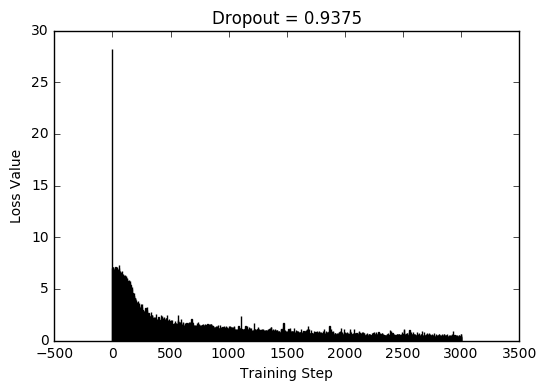

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(1)

plt.bar(np.arange(0,len(loss_values)), loss_values, align='center')
plt.title('Dropout = 60%')
plt.xlabel('Training Step')
plt.ylabel('Loss Value')

plt.show()

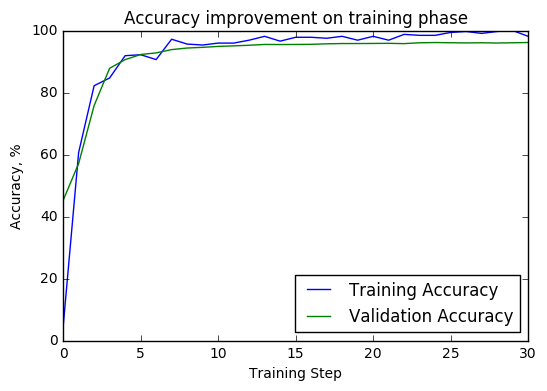

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(2)

plt.plot(np.arange(0,len(train_accuracies)), train_accuracies, label = 'Training Accuracy')
plt.plot(np.arange(0,len(validation_accuracies)), validation_accuracies, label = 'Validation Accuracy')
plt.legend(loc='lower right')

plt.title('Learning Curve: Training-Validation')
plt.xlabel('Training Step')
plt.ylabel('Accuracy, %')

plt.show()